In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [7]:
import numpy as np
x_test = np.load('/home/jovyan/X-IIoTID/x_test.npy')
x_train = np.load('/home/jovyan/X-IIoTID/x_train.npy')
x_val = np.load('/home/jovyan/X-IIoTID/x_val.npy')
y_test = np.load('/home/jovyan/X-IIoTID/y_test.npy')
y_train = np.load('/home/jovyan/X-IIoTID/y_train.npy')
y_val = np.load('/home/jovyan/X-IIoTID/y_val.npy')

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path


# 定义参数
dt_params = {
    'max_depth': [None] + list(range(1, 21)),  # 树的最大深度
    'min_samples_split': range(2, 21),  # 分割所需的最小样本数
    'min_samples_leaf': range(1, 21)  # 叶节点的最小样本数
}

# 确保结果目录存在
result_dir = Path('/content/drive/MyDrive/Cybersecurity/Datasets/results')
if not result_dir.exists():
    result_dir.mkdir()

def tune_with_halving_grid_search_dt(x_train, y_train, param_grid):
    dt = DecisionTreeClassifier()

    start = time()
    halving_dt_results = HalvingGridSearchCV(
        dt,
        param_grid,
        cv=5,
        factor=2,
        min_resources='exhaust',
        scoring='accuracy'
    ).fit(x_train, y_train)

    duration = time() - start

    results = pd.DataFrame(halving_dt_results.cv_results_)
    results.to_csv(result_dir / 'halving_dt_results.csv')

    # 格式化和排序结果
    results = results.loc[:, ('iter', 'rank_test_score', 'mean_test_score', 'params')]
    results.sort_values(by=['iter', 'rank_test_score'], ascending=[False, True], inplace=True)

    return results, duration

# 使用验证数据集进行参数调整
halving_results, halving_duration = tune_with_halving_grid_search_dt(x_val, y_val, dt_params)

print(halving_results.head())

# 获取最佳参数和分数
best_score = halving_results['mean_test_score'].iloc[0]
best_params = halving_results['params'].iloc[0]

# 使用最佳参数训练决策树模型
best_dt = DecisionTreeClassifier(**best_params)
best_dt.fit(x_train, y_train)

# 在测试集上评估
accuracy = accuracy_score(y_test, best_dt.predict(x_test))
micro_f1 = f1_score_rep(y_test, best_dt.predict(x_test), average="micro")
macro_f1 = f1_score_rep(y_test, best_dt.predict(x_test), average="macro")

# 打印结果
print(f'Best score for HalvingGridSearchCV is {best_score:.3f}, took {halving_duration:.2f} seconds')
print(f'Params: {best_params}')
print(f'Corresponding test accuracy: {accuracy * 100:.2f}%')
print("Micro F1 Score: ", micro_f1)
print("Macro F1 Score: ", macro_f1)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Cybersecurity/Datasets/results'

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score as f1_score_rep
import numpy as np
import pandas as pd
from time import time
from pathlib import Path
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.datasets import load_digits

best_dt = DecisionTreeClassifier(max_depth= 20, min_samples_leaf=7, min_samples_split=12)
best_dt.fit(x_train, y_train)



DecisionTreeClassifier(max_depth=20, min_samples_leaf=7, min_samples_split=12)

FPR: [6.87905100e-05 1.86166404e-04 0.00000000e+00 1.21610566e-03
 7.36360758e-05 0.00000000e+00 7.18313400e-05 2.33713558e-04
 1.32285826e-04 0.00000000e+00 1.43844533e-05 9.98457392e-03
 8.01262790e-06 7.14147986e-05 2.68843302e-04 2.57497836e-04
 4.28146340e-05 1.57141735e-04 1.45684462e-05]
TPR: [0.99989359 0.86666667 0.99761337 0.93649747 0.99909645 0.8
 0.99014778 0.99657399 0.99663542 0.59090909 0.99664148 0.99641798
 0.99896286 0.94581281 0.99446465 0.76122931 0.93406593 0.6768559
 0.99864269]
FNR: [1.06405618e-04 1.33333333e-01 2.38663484e-03 6.35025269e-02
 9.03546420e-04 2.00000000e-01 9.85221675e-03 3.42601133e-03
 3.36457582e-03 4.09090909e-01 3.35852225e-03 3.58202341e-03
 1.03714267e-03 5.41871921e-02 5.53534715e-03 2.38770686e-01
 6.59340659e-02 3.23144105e-01 1.35731252e-03]
TNR: [0.99993121 0.99981383 1.         0.99878389 0.99992636 1.
 0.99992817 0.99976629 0.99986771 1.         0.99998562 0.99001543
 0.99999199 0.99992859 0.99973116 0.9997425  0.99995719 0.99984286

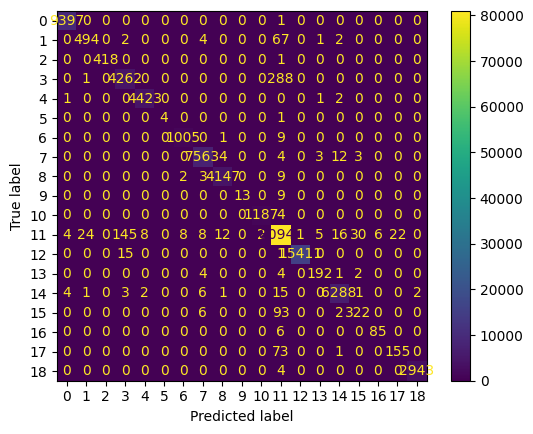

In [9]:
y_pred = best_dt.predict(x_test)

conf_matrix = confusion_matrix(y_test, y_pred)
# tn, fp, fn, tp = conf_matrix.ravel()
cm = conf_matrix
fp = cm.sum(axis=0) - np.diag(cm)
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.sum() - (fp + fn + tp)


fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
precision = precision_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
auc = roc_auc_score(y_test, best_dt.predict_proba(x_test), multi_class='ovr')

print(f"FPR: {fpr}")
print(f"TPR: {tpr}")
print(f"FNR: {fnr}")
print(f"TNR: {tnr}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1-score: {f1}")
print(f"AUC: {auc}")

print(f"FPR: {np.mean(fpr)}")
print(f"tpr: {np.mean(tpr)}")
print(f"fnr: {np.mean(fnr)}")
print(f"tnr: {np.mean(tnr)}")

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=best_dt.classes_)
disp.plot()
plt.show()

In [10]:
print(tp)
print(tn)
print(fp)
print(fn)

[ 9397   494   418  4262  4423     4  1005  7563  4147    13  1187 80948
 15411   192  6288   322    85   155  2943]
[130823 139634 139811 135514 135793 140225 139205 132610 136051 140208
 139037  58402 124802 140017 133871 139771 140133 139979 137281]
[  9  26   0 165  10   0  10  31  18   0   2 589   1  10  36  36   6  22
   2]
[  1  76   1 289   4   1  10  26  14   9   4 291  16  11  35 101   6  74
   4]


In [1]:
import numpy as np
x_test = np.load('/home/jovyan/X-IIoTID/x_test.npy')
x_train = np.load('/home/jovyan/X-IIoTID/x_train.npy')
x_val = np.load('/home/jovyan/X-IIoTID/x_val.npy')
y_test = np.load('/home/jovyan/X-IIoTID/y_test.npy')
y_train = np.load('/home/jovyan/X-IIoTID/y_train.npy')
y_val = np.load('/home/jovyan/X-IIoTID/y_val.npy')

from joblib import dump, load
from sklearn.tree import DecisionTreeClassifier

best_dt = DecisionTreeClassifier(max_depth= 20, min_samples_leaf=7, min_samples_split=12)
best_dt.fit(x_train, y_train)

dump(best_dt, "/home/jovyan/X-IIoTID/pre_train/DT.joblib")

['/home/jovyan/X-IIoTID/pre_train/DT.joblib']